# 必要パッケージインストール

In [ ]:
!pip install onnx onnxruntime==1.15.1
!pip install git+https://github.com/facebookresearch/segment-anything.git

# モデル選択

In [2]:
target_model = 'vit_b'  # 'vit_b', 'vit_l', 'vit_h'

In [3]:
pth_model_name = 'sam_' + target_model + '.pth'
onnx_encoder_model_name = target_model + '_encoder.onnx'
onnx_decoder_model_name = target_model + '_decoder.onnx'

# 学習済重みダウンロード

In [4]:
if target_model == 'vit_b':
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O $pth_model_name
elif target_model == 'vit_l':  # ハイメモリ ランタイム が必須
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth -O $pth_model_name
elif target_model == 'vit_h':  # ハイメモリ ランタイム が必須
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O $pth_model_name

--2024-04-08 11:13:06--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.128, 13.35.7.82, 13.35.7.38, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b.pth’

sam_vit_b.pth       100%[===================>] 357.67M   115MB/s    in 3.4s    

2024-04-08 11:13:09 (106 MB/s) - ‘sam_vit_b.pth’ saved [375042383/375042383]



# ONNXエクスポート（エンコーダー）

In [5]:
import torch
from segment_anything import sam_model_registry

In [6]:
# モデルロード
sam_model = sam_model_registry[target_model](checkpoint=pth_model_name)

In [ ]:
# ONNXエクスポート
torch.onnx.export(
    f=onnx_encoder_model_name,
    model=sam_model.image_encoder,
    args=torch.randn(1, 3, 1024, 1024),
    input_names=["image"],
    output_names=["embedding"],
    export_params=True
)

# ONNXエクスポート（デコーダー）

In [8]:
from segment_anything.utils.onnx import SamOnnxModel

In [9]:
# 入出力情報
embed_dim = sam_model.prompt_encoder.embed_dim
image_embedding_size = sam_model.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in image_embedding_size]
dummy_inputs = {
    "image_embedding": torch.randn(1, embed_dim, *image_embedding_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "scores", "logits"]

# ONNX出力用SAMモデル生成
sam_model_for_onnx = SamOnnxModel(sam_model, return_single_mask=True)

# ONNXエクスポート
torch.onnx.export(
    f=onnx_decoder_model_name,
    model=sam_model_for_onnx,
    args=tuple(dummy_inputs.values()),
    input_names=list(dummy_inputs.keys()),
    output_names=output_names,
    dynamic_axes={
        "point_coords": {1: "num_points"},
        "point_labels": {1: "num_points"}
    },
    export_params=True,
    opset_version=17,
    do_constant_folding=True
)

/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/transformer.py:232: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  attn = attn / math.sqrt(c_per_head)
/usr/local/lib/python3.10/dist-packages/segment_anything/utils/onnx.py:97: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  score_reweight = torch.tensor(
/usr/local/lib/python3.10/dist-packages/torch/onnx/symbolic_opset9.py:5859: UserWarning: Exporting aten::index operator of advanced indexing in opset 17 is achieved by combination of multiple ONNX opera

# 動作確認：画像前処理用関数

In [10]:
import cv2
import numpy as np

In [11]:
def preprocess_image(
    image,
    resize_width=1024,
    mean=np.array([123.675, 116.28, 103.53]),
    std=np.array([[58.395, 57.12, 57.375]])
):
    # BGR -> RGB
    temp_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 長辺を最大長（デフォルト：1024）にあわせてリサイズ
    image_width, image_height = temp_image.shape[1], temp_image.shape[0]
    resize_image_width, resize_image_height = image_width, image_height

    if image_width > image_height:
        resize_image_width = resize_width
        resize_image_height = int((resize_width / image_width) * image_height)
    else:
        resize_image_width = resize_width
        resize_image_height = int((resize_width / image_height) * image_width)

    temp_image = cv2.resize(temp_image, (resize_image_width, resize_image_height))

    resize_info = {
        "image_width": image_width,
        "image_height": image_height,
        "resize_image_width": resize_image_width,
        "resize_image_height": resize_image_height,
    }

    # 正規化
    temp_image = (temp_image - mean) / std

    # 入力シェイプにあわせてリシェイプ
    temp_image = temp_image.transpose(2, 0, 1)[None, :, :, :].astype(np.float32)

    # 最大長（デフォルト：1024）にあわせてパディング
    if resize_image_height < resize_image_width:
        temp_image = np.pad(
            temp_image,
            (
                (0, 0),
                (0, 0),
                (0, resize_width - resize_image_height),
                (0, 0)
            )
        )
    else:
        temp_image = np.pad(
            temp_image,
            (
                (0, 0),
                (0, 0),
                (0, 0),
                (0, resize_width - resize_image_width)
            )
        )

    return temp_image, resize_info

# 動作確認（エンコーダー）

In [12]:
import onnxruntime

from google.colab.patches import cv2_imshow

In [13]:
# サンプル画像ダウンロード
!wget https://user0514.cdnw.net/shared/img/thumb/KAZUHIRO171013006_TP_V4.jpg -O sample.jpg

--2024-04-08 11:13:34--  https://user0514.cdnw.net/shared/img/thumb/KAZUHIRO171013006_TP_V4.jpg
Resolving user0514.cdnw.net (user0514.cdnw.net)... 172.233.81.82
Connecting to user0514.cdnw.net (user0514.cdnw.net)|172.233.81.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90239 (88K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]  88.12K  --.-KB/s    in 0.1s    

2024-04-08 11:13:34 (812 KB/s) - ‘sample.jpg’ saved [90239/90239]



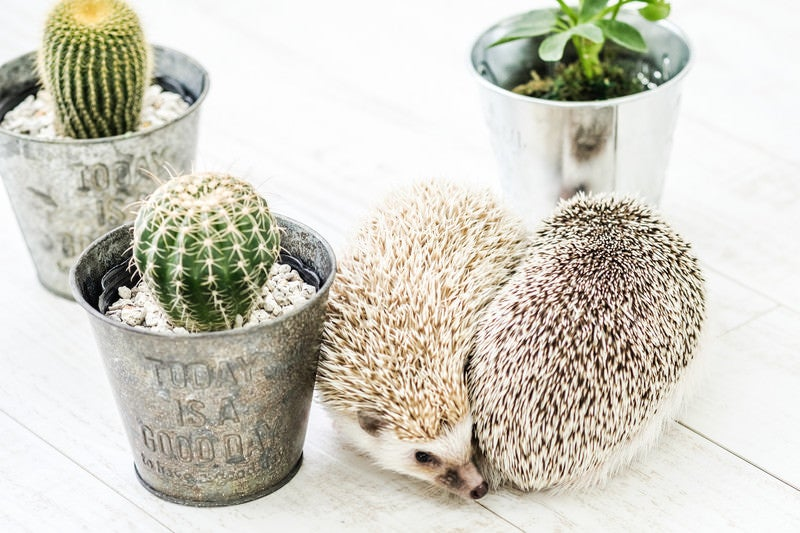

In [14]:
image = cv2.imread('sample.jpg')
cv2_imshow(image)

In [15]:
# 入力画像の前処理を実施
preprocessed_image, resize_info = preprocess_image(image)

In [16]:
# エンコーダーセッション生成
encoder_model = onnxruntime.InferenceSession(
    onnx_encoder_model_name,
    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'],
)

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [17]:
%%time
# エンコーダーで推論して、埋め込みベクトルを取得
embedding = encoder_model.run(None, {'image': preprocessed_image})[0]

CPU times: user 24.7 s, sys: 1.24 s, total: 26 s
Wall time: 7.04 s


In [18]:
print(embedding.shape)

(1, 256, 64, 64)


# 動作確認：座標前処理用関数

In [19]:
def preprocess_point(input_point, input_label, resize_info):
    temp_input_point = np.array(input_point).astype(np.float32)
    temp_input_label = np.array(input_label).astype(np.float32)

    points = temp_input_point.reshape(-1, 2)
    points[..., 0] = points[..., 0] * (resize_info['resize_image_width'] / resize_info['image_width'])
    points[..., 1] = points[..., 1] * (resize_info['resize_image_height'] / resize_info['image_height'])

    labels = temp_input_label.flatten()

    points = points[np.newaxis, :, :]
    labels = labels[np.newaxis, :]

    return points, labels

# 動作確認（デコーダー）：単一座標

In [20]:
import copy

In [21]:
target_point = [420, 300]
target_label = [1]

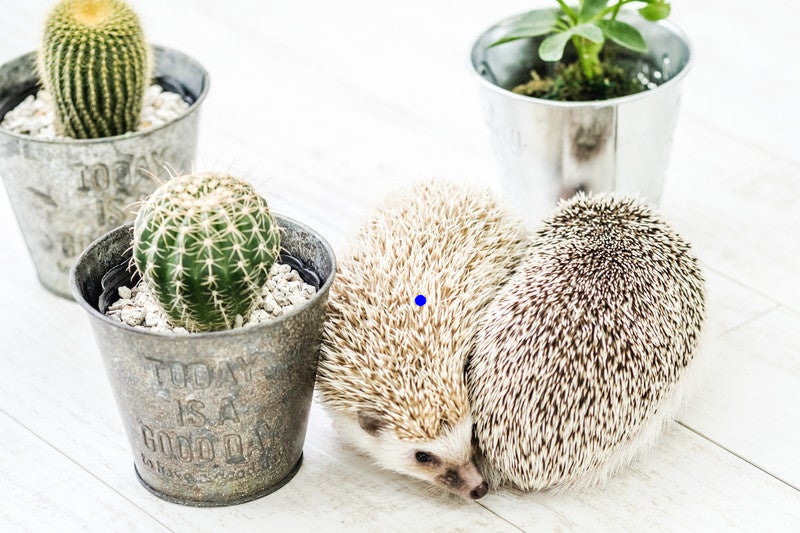

In [22]:
debug_image = copy.deepcopy(image)
debug_image = cv2.circle(debug_image, target_point, 5, (255, 0, 0), -1, lineType=cv2.LINE_AA)
cv2_imshow(debug_image)

In [23]:
# 入力座標とラベルの前処理を実施
input_point, input_label = preprocess_point(
    input_point=target_point,
    input_label=target_label,
    resize_info=resize_info,
)

In [24]:
# デコーダーセッション生成
decoder_model = onnxruntime.InferenceSession(
    onnx_decoder_model_name,
    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'],
)

In [25]:
%%time
masks, scores, logits = decoder_model.run(None,{
    "image_embedding": embedding,
    "point_coords": input_point,
    "point_labels": input_label,
    "mask_input": np.zeros((1, 1, 256, 256), dtype=np.float32),
    "has_mask_input": np.zeros(1, dtype=np.float32),
    "orig_im_size": np.array([resize_info['image_height'], resize_info['image_width']], dtype=np.float32)
})

CPU times: user 213 ms, sys: 0 ns, total: 213 ms
Wall time: 56 ms


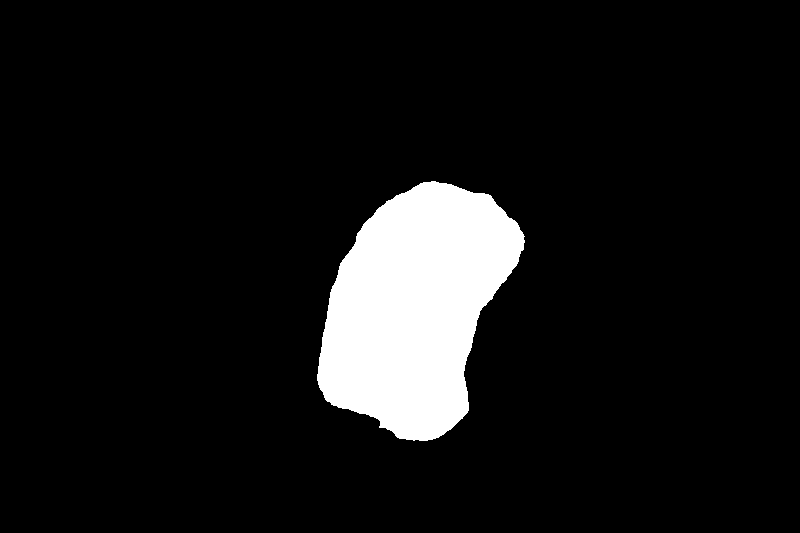

In [26]:
# マスク画像後処理
mask_image = masks[0][0]
mask_image = (mask_image > 0).astype('uint8')*255

cv2_imshow(mask_image)

# 動作確認（デコーダー）：複数座標

In [27]:
import copy

In [28]:
target_points = [[420, 300], [400, 460], [600, 300]]
target_labels = [1, 1, 1]

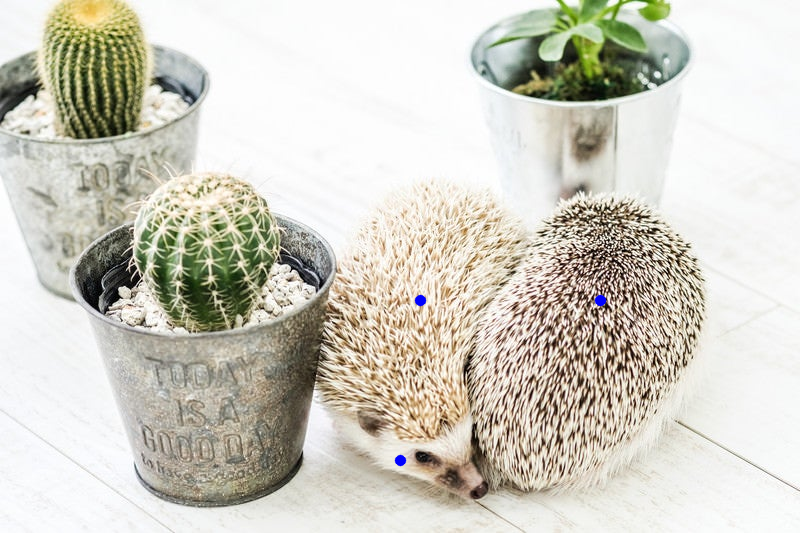

In [29]:
debug_image = copy.deepcopy(image)
for target_point, target_label in zip(target_points, target_labels):
    if target_label == 0:
        color = (0, 0, 255)
    elif target_label == 1:
        color = (255, 0, 0)
    cv2.circle(debug_image, target_point, 5, color, -1, lineType=cv2.LINE_AA)
cv2_imshow(debug_image)

In [30]:
# 入力座標とラベルの前処理を実施
input_point, input_label = preprocess_point(
    input_point=target_points,
    input_label=target_labels,
    resize_info=resize_info,
)

In [31]:
# デコーダーセッション生成
decoder_model = onnxruntime.InferenceSession(
    onnx_decoder_model_name,
    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'],
)

In [32]:
%%time
masks, scores, logits = decoder_model.run(None,{
    "image_embedding": embedding,
    "point_coords": input_point,
    "point_labels": input_label,
    "mask_input": np.zeros((1, 1, 256, 256), dtype=np.float32),
    "has_mask_input": np.zeros(1, dtype=np.float32),
    "orig_im_size": np.array([resize_info['image_height'], resize_info['image_width']], dtype=np.float32)
})

CPU times: user 266 ms, sys: 2 ms, total: 268 ms
Wall time: 67.3 ms


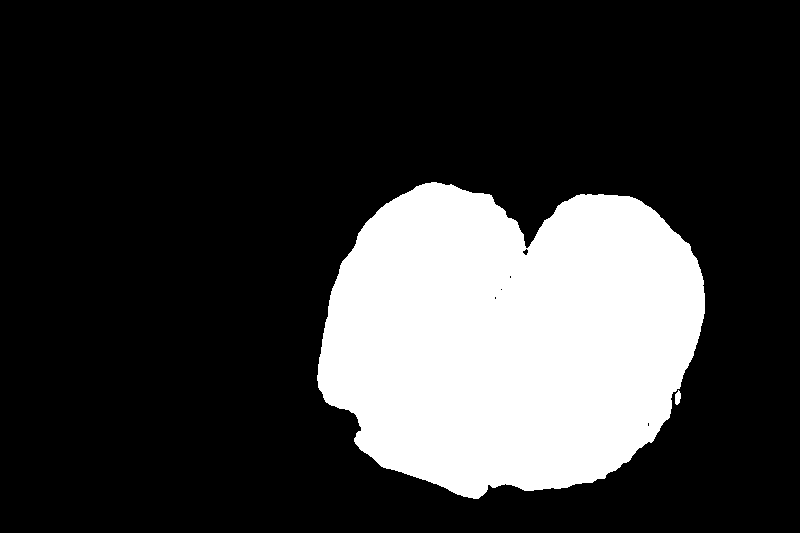

In [33]:
# マスク画像後処理
mask_image = masks[0][0]
mask_image = (mask_image > 0).astype('uint8')*255

cv2_imshow(mask_image)

# 動作確認（デコーダー）：複数座標(非対象指定)

In [34]:
import copy

In [35]:
target_points = [[420, 300], [400, 460], [600, 300]]
target_labels = [1, 0, 1]  # 対象、非対象、対象

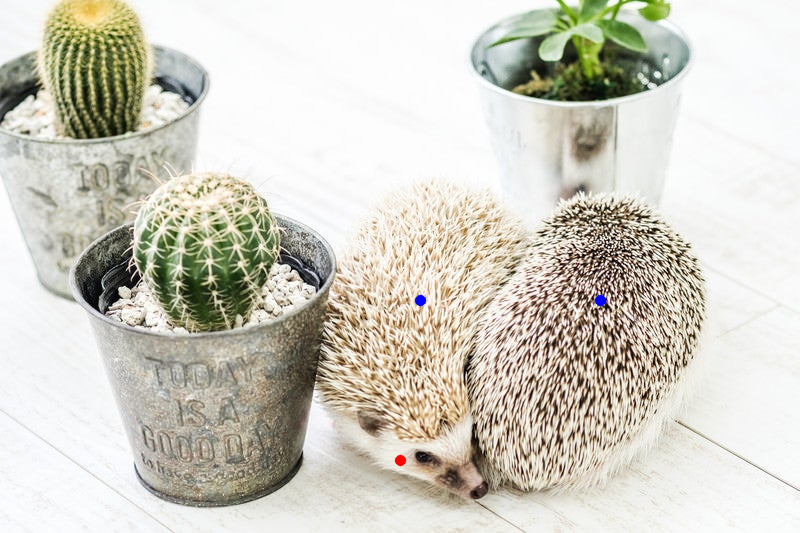

In [36]:
debug_image = copy.deepcopy(image)
for target_point, target_label in zip(target_points, target_labels):
    if target_label == 0:
        color = (0, 0, 255)
    elif target_label == 1:
        color = (255, 0, 0)
    cv2.circle(debug_image, target_point, 5, color, -1, lineType=cv2.LINE_AA)
cv2_imshow(debug_image)

In [37]:
# 入力座標とラベルの前処理を実施
input_point, input_label = preprocess_point(
    input_point=target_points,
    input_label=target_labels,
    resize_info=resize_info,
)

In [38]:
# デコーダーセッション生成
decoder_model = onnxruntime.InferenceSession(
    onnx_decoder_model_name,
    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'],
)

In [39]:
%%time
masks, scores, logits = decoder_model.run(None,{
    "image_embedding": embedding,
    "point_coords": input_point,
    "point_labels": input_label,
    "mask_input": np.zeros((1, 1, 256, 256), dtype=np.float32),
    "has_mask_input": np.zeros(1, dtype=np.float32),
    "orig_im_size": np.array([resize_info['image_height'], resize_info['image_width']], dtype=np.float32)
})

CPU times: user 226 ms, sys: 587 µs, total: 227 ms
Wall time: 58 ms


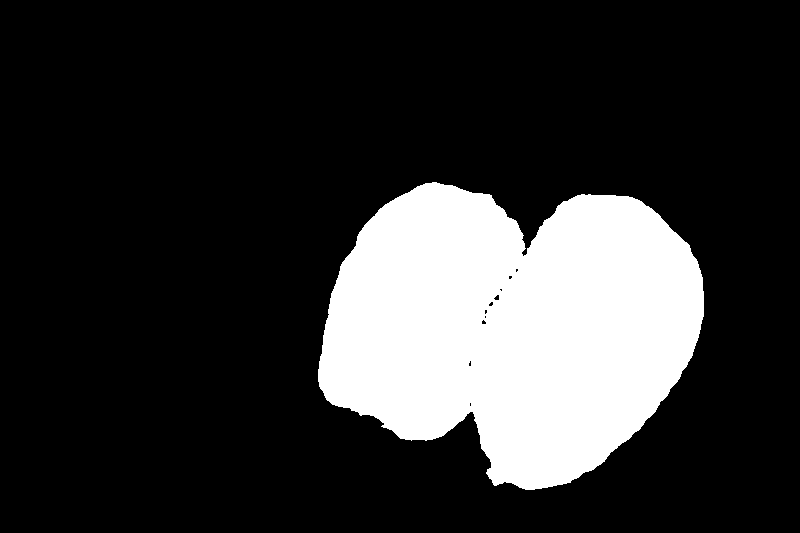

In [40]:
# マスク画像後処理
mask_image = masks[0][0]
mask_image = (mask_image > 0).astype('uint8')*255

cv2_imshow(mask_image)

# 動作確認（デコーダー）：バウンディングボックス

In [41]:
import copy

In [42]:
target_bbox = [300, 175, 525, 500]
target_label = [2, 3]

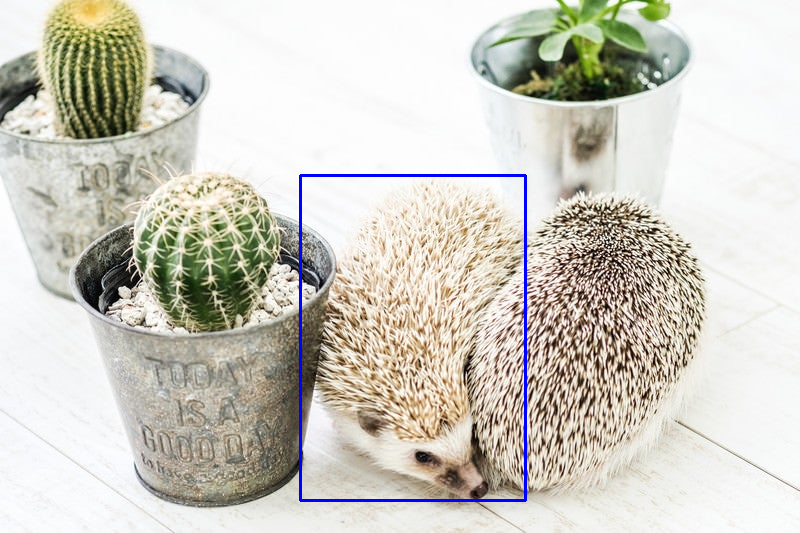

In [43]:
debug_image = copy.deepcopy(image)
cv2.rectangle(
    debug_image,
    (target_bbox[0], target_bbox[1]),
    (target_bbox[2], target_bbox[3]),
    (255, 0, 0),
    2,
)
cv2_imshow(debug_image)

In [44]:
# 入力座標とラベルの前処理を実施
input_point, input_label = preprocess_point(
    input_point=target_bbox,
    input_label=target_label,
    resize_info=resize_info,
)

In [45]:
%%time
masks, scores, logits = decoder_model.run(None,{
    "image_embedding": embedding,
    "point_coords": input_point,
    "point_labels": input_label,
    "mask_input": np.zeros((1, 1, 256, 256), dtype=np.float32),
    "has_mask_input": np.zeros(1, dtype=np.float32),
    "orig_im_size": np.array([resize_info['image_height'], resize_info['image_width']], dtype=np.float32)
})

CPU times: user 258 ms, sys: 0 ns, total: 258 ms
Wall time: 66.6 ms


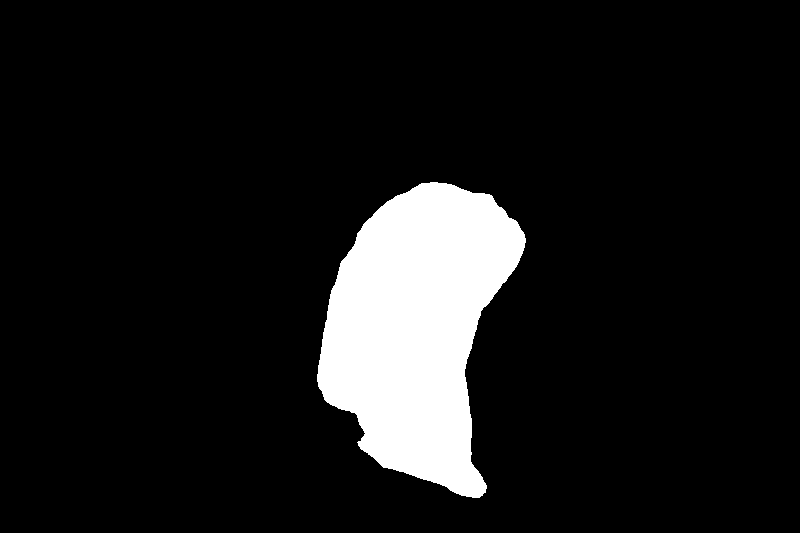

In [46]:
# マスク画像後処理
mask_image = masks[0][0]
mask_image = (mask_image > 0).astype('uint8')*255

cv2_imshow(mask_image)

# 動作確認（デコーダー）：バウンディングボックス＋座標

In [47]:
import copy

In [48]:
# バウンディングボックス
target_bbox = [300, 175, 525, 500]
target_bbox_label = [2, 3]

# 座標
target_point = [400, 460]
target_point_label = [0]  # 非対象

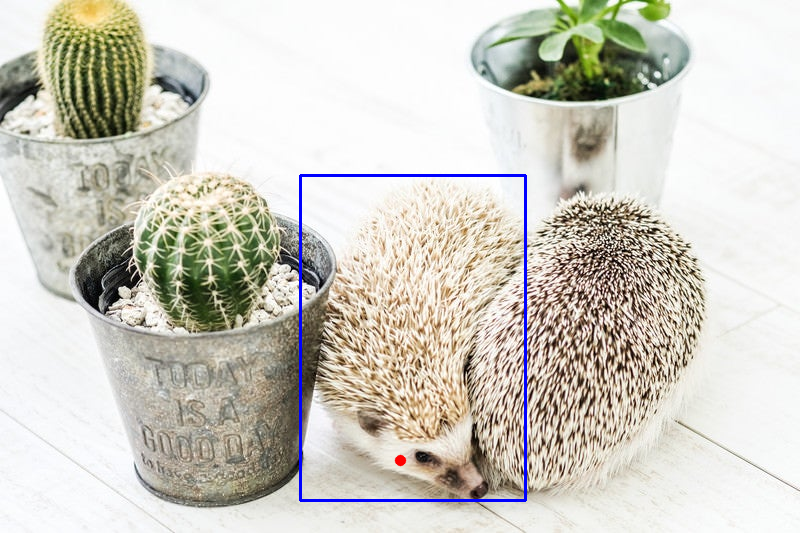

In [49]:
debug_image = copy.deepcopy(image)
cv2.rectangle(
    debug_image,
    (target_bbox[0], target_bbox[1]),
    (target_bbox[2], target_bbox[3]),
    (255, 0, 0),
    2,
)
cv2.circle(debug_image, target_point, 5, (0, 0, 255), -1, lineType=cv2.LINE_AA)
cv2_imshow(debug_image)

In [50]:
# 座標列を連結
target_points = target_bbox + target_point
target_labels = target_bbox_label + target_point_label

# 入力座標とラベルの前処理を実施
input_point, input_label = preprocess_point(
    input_point=target_points,
    input_label=target_labels,
    resize_info=resize_info,
)

In [51]:
%%time
masks, scores, logits = decoder_model.run(None,{
    "image_embedding": embedding,
    "point_coords": input_point,
    "point_labels": input_label,
    "mask_input": np.zeros((1, 1, 256, 256), dtype=np.float32),
    "has_mask_input": np.zeros(1, dtype=np.float32),
    "orig_im_size": np.array([resize_info['image_height'], resize_info['image_width']], dtype=np.float32)
})

CPU times: user 229 ms, sys: 0 ns, total: 229 ms
Wall time: 59 ms


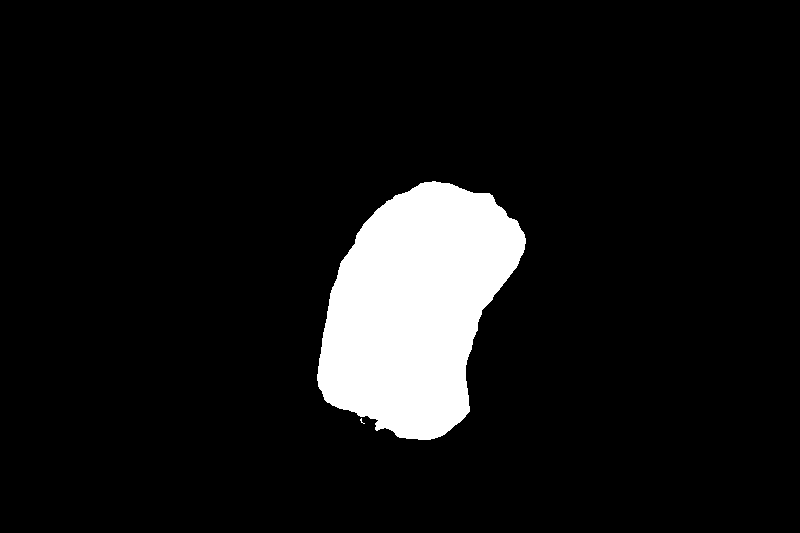

In [52]:
# マスク画像後処理
mask_image = masks[0][0]
mask_image = (mask_image > 0).astype('uint8')*255

cv2_imshow(mask_image)

# ONNXファイルダウンロード

In [ ]:
!mkdir onnx_model
!cp $onnx_encoder_model_name onnx_model
!cp $onnx_decoder_model_name onnx_model
!zip -r onnx_model.zip onnx_model

In [54]:
from google.colab import files
files.download("onnx_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>